In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from glob import glob
import re


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Data loading and Processing

In [21]:
IMAGE_DIR = '/content/drive/MyDrive/Formative2-DataPreprocessing/images'
OUTPUT_CSV = '/content/image_features.csv'  # Save to /content/ directory (writable)
IMAGE_SIZE = (128, 128)
DISPLAY_EXPRESSION = 'smiling'  # Only display this expression (use 'all' to show everything)


In [10]:
def parse_filename(filename):
    """Extract member name and expression from filename"""
    basename = os.path.splitext(os.path.basename(filename))[0]
    # Split by last hyphen to handle names with hyphens
    parts = basename.rsplit('-', 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return basename, 'unknown'

In [24]:
extensions = ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG']
image_paths = []
for ext in extensions:
    image_paths.extend(glob(os.path.join(IMAGE_DIR, ext)))

images_data = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        member, expression = parse_filename(path)
        images_data.append({
            'path': path,
            'image': img,
            'member': member,
            'expression': expression
        })


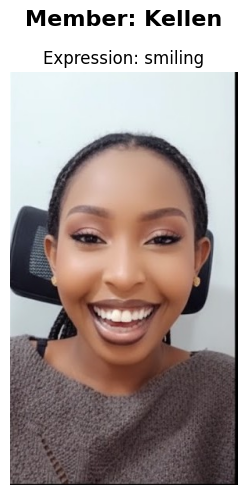

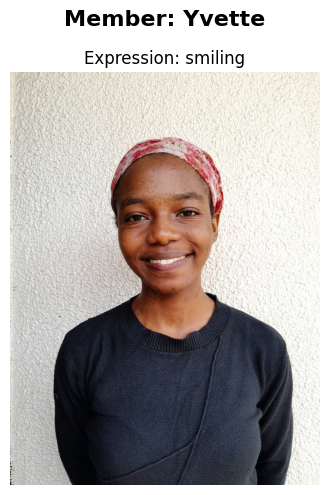

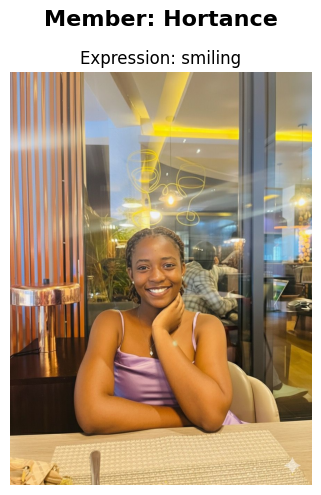

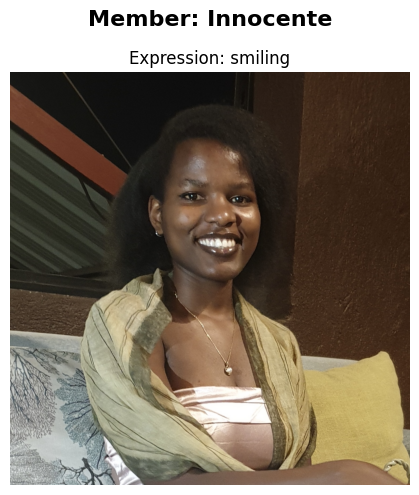

In [25]:
images_data_toDisplay = [img for img in images_data if img['expression'].lower() == 'smiling']

members = {}
for img_data in images_data_toDisplay:
    member = img_data['member']
    if member not in members:
        members[member] = []
    members[member].append(img_data)

# Display samples
for member, imgs in members.items():
    n_images = len(imgs)
    cols = min(3, n_images)
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    fig.suptitle(f'Member: {member}', fontsize=16, fontweight='bold')

    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if rows > 1 else axes

    for idx, img_data in enumerate(imgs):
        if idx < len(axes):
            axes[idx].imshow(img_data['image'])
            axes[idx].set_title(f"Expression: {img_data['expression']}")
            axes[idx].axis('off')

    # Hide extra subplots
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
def augment_image(img):
    """Apply various augmentations to an image"""
    augmentations = {}

    # Original (resized)
    img_resized = cv2.resize(img, IMAGE_SIZE)
    augmentations['original'] = img_resized

    # Rotation (15 degrees)
    h, w = img_resized.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, 15, 1.0)
    augmentations['rotated'] = cv2.warpAffine(img_resized, matrix, (w, h))

    # Horizontal flip
    augmentations['flipped'] = cv2.flip(img_resized, 1)

    # Grayscale
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    augmentations['grayscale'] = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # Brightness adjustment
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * 1.2, 0, 255)
    augmentations['brightness'] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return augmentations

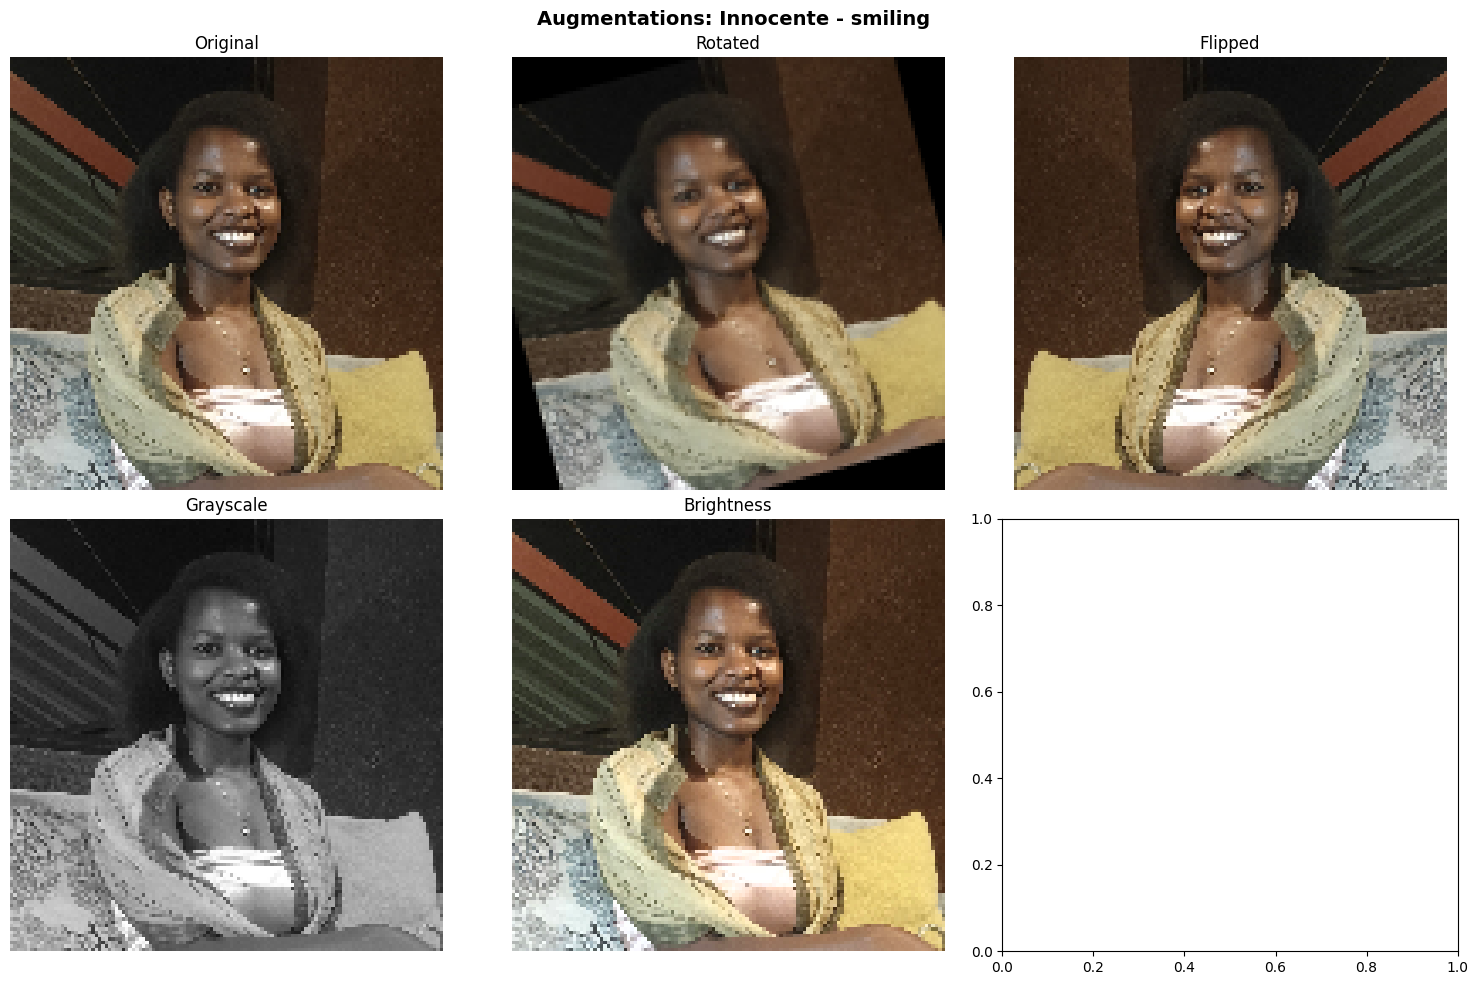

In [16]:
augmentations = augment_image(img_data['image'])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f"Augmentations: {img_data['member']} - {img_data['expression']}",
              fontsize=14, fontweight='bold')

axes = axes.flatten()
for idx, (aug_name, aug_img) in enumerate(augmentations.items()):
    if idx < len(axes):
        axes[idx].imshow(aug_img)
        axes[idx].set_title(aug_name.capitalize())
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [17]:
def extract_color_histogram(img, bins=32):
    """Extract color histogram features"""
    features = []
    for channel in range(3):
        hist = cv2.calcHist([img], [channel], None, [bins], [0, 256])
        hist = hist.flatten() / hist.sum()  # Normalize
        features.extend(hist)
    return features

def extract_texture_features(img):
    """Extract texture features using Laplacian"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    features = [
        np.mean(laplacian),
        np.std(laplacian),
        np.min(laplacian),
        np.max(laplacian)
    ]
    return features

def extract_shape_features(img):
    """Extract basic shape/edge features"""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    features = [
        np.mean(edges),
        np.std(edges),
        np.sum(edges > 0)  # Edge pixel count
    ]
    return features

def extract_all_features(img):
    """Combine all feature extraction methods"""
    img_resized = cv2.resize(img, IMAGE_SIZE)

    features = []
    features.extend(extract_color_histogram(img_resized))
    features.extend(extract_texture_features(img_resized))
    features.extend(extract_shape_features(img_resized))

    return features

In [26]:
all_features = []

print(f"Processing {len(images_data)} images...")

for idx, img_data in enumerate(images_data):
    # Extract features from original image
    features = extract_all_features(img_data['image'])

    # Apply augmentations and extract features
    augmentations = augment_image(img_data['image'])

    for aug_name, aug_img in augmentations.items():
        aug_features = extract_all_features(aug_img)

        feature_row = {
            'member': img_data['member'],
            'expression': img_data['expression'],
            'augmentation': aug_name,
            'filename': os.path.basename(img_data['path'])
        }

        # Add features with column names
        for i, feat in enumerate(aug_features):
            feature_row[f'feature_{i}'] = feat

        all_features.append(feature_row)

    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{len(images_data)} images...")

# Create DataFrame and save
df = pd.DataFrame(all_features)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✓ Features saved to {OUTPUT_CSV}")
print(f"✓ You can download it from the Colab files panel on the left")
print(f"✓ Total feature rows: {len(df)}")
print(f"✓ Feature dimensions: {len([col for col in df.columns if col.startswith('feature_')])}")


Processing 12 images...
Processed 10/12 images...

✓ Features saved to /content/image_features.csv
✓ You can download it from the Colab files panel on the left
✓ Total feature rows: 60
✓ Feature dimensions: 103
